In [1]:
# 1. Clone the repo to get the helper script (threshold_detector.py)
!git clone https://github.com/NirLab-TAU/iEEG_ied_detection.git

# 2. Move into the folder so the notebook can find the files
import os
os.chdir('/content/iEEG_ied_detection')

# 3. Install all the specific neuro-engineering libraries
!pip install -r requirements.txt
!pip install mne-bids antropy mne-features lightgbm

Cloning into 'iEEG_ied_detection'...
remote: Enumerating objects: 46, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 46 (delta 17), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (46/46), 109.62 KiB | 1.86 MiB/s, done.
Resolving deltas: 100% (17/17), done.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 76.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 52.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to 

In [1]:
import os
os.chdir('/content/iEEG_ied_detection')

In [2]:
import mne
import pandas as pd
import numpy as np
import antropy as ant
import scipy.stats as sp_stats
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
import shap
import matplotlib.pyplot as plt
from mne_features.feature_extraction import extract_features
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix
from mne_bids import BIDSPath, read_raw_bids

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Utils functions

In [6]:
# create a dictionary with the onsets of each channel
def onset_per_chan(subj):
    # load the list of channels for each annotation
    tags_df = pd.read_csv(rf'.\ieeg_ieds_bids\derivatives\sub-{subj}_task-sleep_events_interpretation.tsv', sep='\t')
    result_dict = {}

    # Iterate over the DataFrame rows
    for index, row in tags_df.iterrows():
        onset = row['time_in_sec']
        chans = row['chans']
        for string in chans.split(' '):
            if string not in result_dict:
                result_dict[string] = []
            result_dict[string].append(onset)

    # in case of extra space
    result_dict.pop('', None)
    return result_dict

# extract features from the epochs of a single channel
def extract_epochs_features(epochs, subj, sr):
    mobility, complexity = ant.hjorth_params(epochs, axis=1)
    feat = {
        'subj': np.full(len(epochs), subj),
        'epoch_id': np.arange(len(epochs)),
        'kurtosis': sp_stats.kurtosis(epochs, axis=1),
        'hjorth_mobility': mobility,
        'hjorth_complexity': complexity,
        'ptp_amp': np.ptp(epochs, axis=1),
        'samp_entropy': np.apply_along_axis(ant.sample_entropy, axis=1, arr=epochs)
    }

    # Extract teager-kaiser energy
    X_new = extract_features(np.array(epochs)[:, np.newaxis, :], sr, ['teager_kaiser_energy'], return_as_df=True)
    # rename columns
    X_new.columns = [name[0] + '_' + name[1].replace('ch0_', '') for name in X_new.columns]

    # Convert to dataframe
    feat = pd.DataFrame(feat)
    feat = pd.concat([feat, X_new], axis=1)

    return feat

# get features and labels of a single subject (all channels)
def get_subj_data(subj):
    window_size = 250  # ms
    raw = read_raw_bids(BIDSPath(subject=subj, task='sleep', root='/content/drive/MyDrive/ieeg_ieds_bids', datatype='ieeg'))
    chans_onsets = onset_per_chan(subj)

    y = []
    x = pd.DataFrame()
    # iterate over all channels that have annotations
    for chan in chans_onsets.keys():
        epochs = []
        chan_raw = raw.copy().pick([chan]).get_data().flatten()
        # normalize chan
        chan_norm = (chan_raw - chan_raw.mean()) / chan_raw.std()
        # run on all 250ms epochs excluding the last 1s
        for i in range(0, len(chan_norm) - 4 * window_size, window_size):
            epochs.append(chan_norm[i: i + window_size])

        # mark the spikes in the right index
        curr_y = [0] * len(epochs)
        for onset in chans_onsets[chan]:
            curr_y[int(onset // 0.25)] = 1

        # add epoch-level features
        curr_feat = extract_epochs_features(epochs, subj, raw.info['sfreq'])
        # add channel-level features
        chan_feat = {
            'chan_name': chan,
            'chan_ptp': np.ptp(chan_norm),
            'chan_kurt': sp_stats.kurtosis(chan_norm),
        }

        for feat in chan_feat.keys():
            curr_feat[feat] = chan_feat[feat]

        # save the epochs as column for debugging/visualization
        curr_feat['epoch'] = epochs
        x = pd.concat([x, curr_feat], axis=0)
        y.extend(curr_y)

    return x, y

# Generate the data

In [7]:
# create a dataframe with all the subjects and features
x_all = pd.DataFrame()
y_all = []
for subj in range(1, 26):
    print(subj)
    id = str(subj) if subj >= 10 else f'0{subj}'
    x_subj, y_subj = get_subj_data(id)
    x_all = pd.concat([x_all, x_subj], axis=0)
    y_all.extend(y_subj)

1
Extracting EDF parameters from /content/drive/MyDrive/ieeg_ieds_bids/sub-01/ieeg/sub-01_task-sleep_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /content/drive/MyDrive/ieeg_ieds_bids/sub-01/ieeg/sub-01_task-sleep_events.tsv.
Reading channel info from /content/drive/MyDrive/ieeg_ieds_bids/sub-01/ieeg/sub-01_task-sleep_channels.tsv.
Reading electrode coords from /content/drive/MyDrive/ieeg_ieds_bids/sub-01/ieeg/sub-01_electrodes.tsv.


MNI152Lin is not an MNE-Python coordinate frame for IEEG data and so will be set to 'unknown'
DigMontage is only a subset of info. There are 11 channel positions not present in the DigMontage. The channels missing from the montage are:

['LA1-LA2', 'LA2-LA3', 'LA3-LA4', 'LMH1-LMH2', 'LMH2-LMH3', 'LMH3-LMH4', 'RA1-RA3', 'RA3-RA4', 'RMH1-RMH2', 'RMH2-RMH3', 'RMH3-RMH4'].

Consider using inst.rename_channels to match the montage nomenclature, or inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.


FileNotFoundError: [Errno 2] No such file or directory: '.\\ieeg_ieds_bids\\derivatives\\sub-01_task-sleep_events_interpretation.tsv'

# Under-sampling

In [ ]:
# undersample the majority class
rus = RandomUnderSampler(random_state=42)
x, y = rus.fit_resample(x_all, np.array(y_all))
sum(y)/len(y)

0.5

# Feature selection

In [ ]:
# choose the features to use
meta_data = ['subj', 'epoch_id', 'chan_name', 'epoch']
feat_to_choose = ['teager_kaiser_energy_1_std', 'teager_kaiser_energy_2_std', 'chan_ptp', 'ptp_amp', 'hjorth_mobility', 'hjorth_complexity', 'teager_kaiser_energy_3_std', 'chan_kurt', 'teager_kaiser_energy_5_mean', 'teager_kaiser_energy_0_std', 'kurtosis', 'teager_kaiser_energy_1_mean', 'teager_kaiser_energy_5_std', 'samp_entropy']
# choose best features
x_feat = x[feat_to_choose]
x_feat

,teager_kaiser_energy_1_std,teager_kaiser_energy_2_std,chan_ptp,ptp_amp,hjorth_mobility,hjorth_complexity,teager_kaiser_energy_3_std,chan_kurt,teager_kaiser_energy_5_mean,teager_kaiser_energy_0_std,kurtosis,teager_kaiser_energy_1_mean,teager_kaiser_energy_5_std,samp_entropy
317,0.046473,0.002074,9.506129,1.303298,0.035457,36.174244,0.000541,2.662450,0.000058,6.778727,-1.373971,0.031326,0.000088,0.073556
520,0.008159,0.001426,11.643328,1.166101,0.030020,47.056575,0.000422,5.101268,0.000050,3.145458,-1.299559,0.010812,0.000088,0.046327
141,0.037613,0.012259,16.015686,1.140554,0.044486,19.511480,0.003310,1.013492,0.000044,3.367326,-1.620443,0.016406,0.000068,0.091095
642,0.160384,0.029426,17.534921,1.507632,0.096391,11.784086,0.006521,17.032723,0.000250,10.657995,-0.287102,0.066533,0.000300,0.263168
512,0.161967,0.117311,16.459017,1.181131,0.180640,6.298630,0.028623,2.549787,0.000612,13.076160,-0.776554,0.146398,0.000904,0.672213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
568,2.544303,0.135031,10.012795,4.163106,0.058332,17.150753,0.023949,1.496141,0.000932,47.460212,0.168940,1.167731,0.001444,0.103925
568,2.330141,0.097333,10.376840,3.756648,0.060348,16.153232,0.029416,1.647136,0.000735,35.732287,0.201231,0.936178,0.000894,0.112370
568,1.794002,0.077188,10.930553,3.347359,0.064313,14.937929,0.030545,1.941368,0.000661,25.141064,0.197371,0.775097,0.001071,0.127919
568,2.326437,0.129270,11.319015,4.135271,0.063745,14.995195,0.044203,1.751833,0.000761,32.022184,-0.006241,0.991502,0.001279,0.137286


# Model training and evaluation

In [ ]:
# run k-fold cross validation
metrics = {'accuracy': [], 'precision': [], 'sensitivity': [], 'specificity': [],'f1': [], 'ROCAUC': [], 'PRAUC': []}
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)
for train_index, test_index in kf.split(x_feat, y):
    model = LGBMClassifier()
    x_train_fold, x_test_fold = x_feat.iloc[train_index], x_feat.iloc[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    model.fit(x_train_fold, y_train_fold)
    y_pred = model.predict(x_test_fold)
    y_true = y_test_fold
    # save scores in dict
    metrics['accuracy'].append(accuracy_score(y_true, y_pred))
    metrics['precision'].append(precision_score(y_true, y_pred))
    metrics['sensitivity'].append(recall_score(y_true, y_pred))
    metrics['f1'].append(f1_score(y_true, y_pred))
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    metrics['specificity'].append(tn / (tn + fp))
    metrics['ROCAUC'].append(roc_auc_score(y_true, y_pred))
    metrics['PRAUC'].append(average_precision_score(y_true, y_pred))

# print results as df
results = pd.DataFrame(metrics)
results.loc['mean'] = results.mean()
results

[LightGBM] [Info] Number of positive: 2965, number of negative: 2964
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000636 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3554
[LightGBM] [Info] Number of data points in the train set: 5929, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500084 -> initscore=0.000337
[LightGBM] [Info] Start training from score 0.000337
[LightGBM] [Info] Number of positive: 2964, number of negative: 2965
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3550
[LightGBM] [Info] Number of data points in the train set: 5929, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499916 -> initscore=-0.000337
[LightGBM]

,accuracy,precision,sensitivity,specificity,f1,ROCAUC,PRAUC
0,0.943358,0.944520,0.941970,0.944744,0.943243,0.943357,0.918705
1,0.951450,0.944297,0.959569,0.943320,0.951872,0.951444,0.926347
2,0.939271,0.936913,0.941970,0.936572,0.939435,0.939271,0.911559
3,0.943320,0.942127,0.944669,0.941970,0.943396,0.943320,0.917663
4,0.945344,0.953297,0.936572,0.954116,0.944860,0.945344,0.924545
mean,0.944549,0.944231,0.944950,0.944144,0.944561,0.944547,0.919764


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


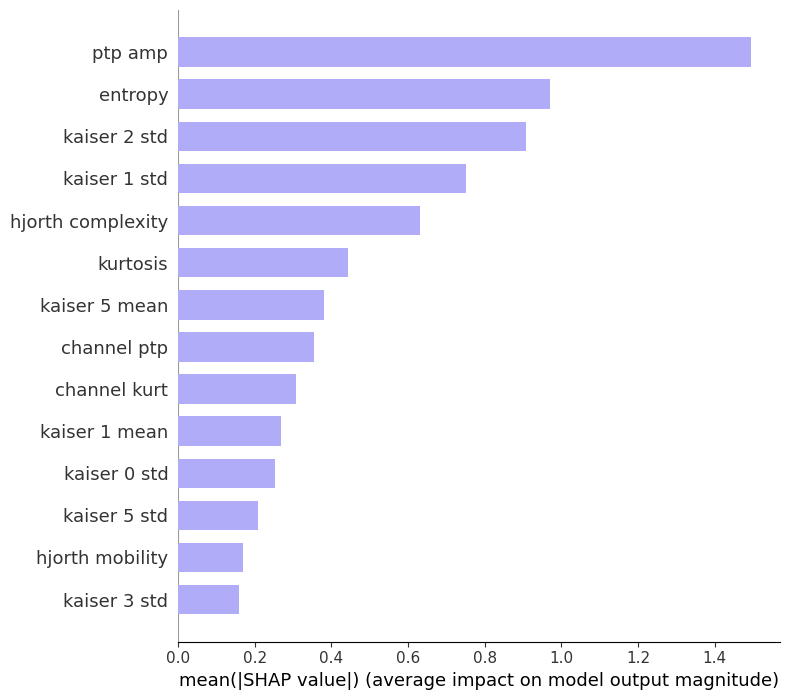

In [ ]:
# use shap to explain model predictions
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_test_fold)
plt.grid(False)
new_names = ['kaiser 1 std', 'kaiser 2 std', 'channel ptp', 'ptp amp', 'hjorth mobility', 'hjorth complexity', 'kaiser 3 std', 'channel kurt', 'kaiser 5 mean', 'kaiser 0 std', 'kurtosis', 'kaiser 1 mean', 'kaiser 5 std', 'entropy']
shap.summary_plot(shap_values[1], x_test_fold, plot_type='bar', color='#b0acf7', feature_names=new_names)

In [ ]:
# leave one subject out cross validation
loo_metrics = {'accuracy': [], 'precision': [], 'sensitivity': [], 'specificity': [],'f1': [], 'ROCAUC': [], 'PRAUC': []}
for subj in range(1, 26):
    id = str(subj) if subj >= 10 else f'0{subj}'
    print(f'Processing subject {subj}')
    model = LGBMClassifier()
    x_train_fold = x_feat[x['subj'] != id]
    x_test_fold = x_feat[x['subj'] == id]
    y_train_fold = y[x['subj'] != id]
    y_test_fold = y[x['subj'] == id]
    model.fit(x_train_fold, y_train_fold)
    y_pred = model.predict(x_test_fold)
    y_true = y_test_fold
    # save scores in dict
    loo_metrics['accuracy'].append(accuracy_score(y_true, y_pred))
    loo_metrics['precision'].append(precision_score(y_true, y_pred))
    loo_metrics['sensitivity'].append(recall_score(y_true, y_pred))
    loo_metrics['f1'].append(f1_score(y_true, y_pred))
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    loo_metrics['specificity'].append(tn / (tn + fp))
    loo_metrics['ROCAUC'].append(roc_auc_score(y_true, y_pred))
    loo_metrics['PRAUC'].append(average_precision_score(y_true, y_pred))

# print results as df
loo_results = pd.DataFrame(loo_metrics)
loo_results

Processing subject 1
[LightGBM] [Info] Number of positive: 3551, number of negative: 3607
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3547
[LightGBM] [Info] Number of data points in the train set: 7158, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496088 -> initscore=-0.015647
[LightGBM] [Info] Start training from score -0.015647
Processing subject 2
[LightGBM] [Info] Number of positive: 3564, number of negative: 3640
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3548
[LightGBM] [Info] Number of data points in the train set: 7204, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.494725 -> initscore=-0.021100
[LightGBM] [Info] Start traini

,accuracy,precision,sensitivity,specificity,f1,ROCAUC,PRAUC
0,0.944882,0.986207,0.922581,0.979798,0.953333,0.951189,0.957099
1,0.947115,0.978102,0.943662,0.954545,0.960573,0.949104,0.961459
2,0.961538,0.931034,1.000000,0.920000,0.964286,0.960000,0.931034
3,0.961538,0.950000,0.950000,0.968750,0.950000,0.959375,0.921731
4,0.966667,0.981013,0.974843,0.941176,0.977918,0.958010,0.975381
5,0.918699,0.895028,0.993865,0.771084,0.941860,0.882475,0.893602
6,0.870968,0.976744,0.857143,0.923077,0.913043,0.890110,0.950113
7,0.952790,0.933962,0.961165,0.946154,0.947368,0.953659,0.914859
8,0.985185,0.970149,1.000000,0.971429,0.984848,0.985714,0.970149
9,0.921296,0.859155,0.897059,0.932432,0.877698,0.914746,0.803120


In [ ]:
# get the average of the metrics
loo_results.mean()

accuracy       0.911656
precision      0.900919
sensitivity    0.871247
specificity    0.929555
f1             0.873558
ROCAUC         0.900401
PRAUC          0.846694
dtype: float64

# Test/usage example on unbalanced data: train without one patient and visualize predictions


In [ ]:
out_subject = '01'
detected_chan = 'RA1'
plot_chans = ['RMH1', 'RMH2', 'RA1']
confidence_threshold = 0.8

model = LGBMClassifier()
x_train_fold, y_train_fold = x_feat[x['subj'] != out_subject], y[x['subj'] != out_subject]
model.fit(x_train_fold, y_train_fold)

# get the features of the continuous data (before the undersampling)
x_for_example, y_for_example = x_all, np.array(y_all)
x_feat_for_example = x_for_example[feat_to_choose]
x_test = x_feat_for_example[(x_for_example['subj'] == out_subject) & (x_for_example['chan_name'] == detected_chan)]
y_test = y_for_example[(x_for_example['subj'] == out_subject) & (x_for_example['chan_name'] == detected_chan)]

# apply the model and plot it on the raw data
y_pred_prob = model.predict_proba(x_test)
y_model = [p > confidence_threshold for p in y_pred_prob.T[1]]
onsets_index = x_test[np.array(y_model)== 1].index
onsets = [int(x) / 4 for x in onsets_index]
real_index = x_test[y_test == 1].index
real_onsets = [int(x) / 4 for x in real_index]
both = [x for x in real_onsets if x in onsets]
annot = mne.Annotations(onsets, [0.25] * len(onsets), ['pred'] * len(onsets)).append(real_onsets, [0.25] * len(real_onsets), ['true'] * len(real_onsets)).append(both, [0.25] * len(both), ['both'] * len(both))
raw = read_raw_bids(BIDSPath(subject=out_subject, task='sleep', root='/content/drive/MyDrive/ieeg_ieds_bid', datatype='ieeg'))
raw.set_annotations(annot)
raw.copy().pick(plot_chans).plot(duration=30, scalings='auto')